# pyphot - A tool for computing photometry from spectra


Some examples are provided in this notebook

Full documentation available at http://mfouesneau.github.io/docs/pyphot/

In [1]:
%matplotlib inline

import pylab as plt
import numpy as np

import sys
sys.path.append('../')
from pyphot import sandbox as pyphot
from pyphot import Vega, Sun

## The Sun and Vega

`pyphot` provides convenient interfaces to a spectral representation of the Sun and Vega.
In this notebook, we show how they can be used.

In [2]:
# get the internal default library of passbands filters
lib = pyphot.get_library()
print("Library contains: ", len(lib), " filters")

Library contains:  256  filters


## Vega

Suppose one has a calibrated spectrum and wants to compute the vega magnitude throug the HST WFC3 F110W passband,

In [3]:
# convert to magnitudes
import numpy as np

# We'll use Vega spectrum as example
vega = Vega()
f = lib['HST_WFC3_F110W']
# compute the integrated flux through the filter f
# note that it work on many spectra at once
fluxes = f.get_flux(vega.wavelength, vega.flux, axis=-1)
# convert to vega magnitudes
mags = -2.5 * np.log10(fluxes.magnitude) - f.Vega_zero_mag
print("Vega magnitude of Vega in {0:s} is : {1:f} mag".format(f.name, mags))
mags = -2.5 * np.log10(fluxes.magnitude) - f.AB_zero_mag
print("AB magnitude of Vega in {0:s} is : {1:f} mag".format(f.name, mags))
mags = -2.5 * np.log10(fluxes.magnitude) - f.ST_zero_mag
print("ST magnitude of Vega in {0:s} is : {1:f} mag".format(f.name, mags))

Vega magnitude of Vega in HST_WFC3_F110W is : 0.000000 mag
AB magnitude of Vega in HST_WFC3_F110W is : 0.751950 mag
ST magnitude of Vega in HST_WFC3_F110W is : 2.372749 mag


In [4]:
f.AB_zero_Jy, f.Vega_zero_Jy, f.ST_zero_Jy

(<Quantity(3630.780547701005, 'Jy')>,
 <Quantity(1816.4359709388373, 'Jy')>,
 <Quantity(16155.469547627858, 'Jy')>)

## The Sun

The internal reference to the Solar spectrum comes in two flavors: an observed one and a theoretical one.
By default, the interface is set to theoretical.

In addition, the Sun is at $1\,au$ but can be set to any distance. Below we instanciate the two flavors and also the Sun if it was at $10\, pc$ (absolute flux units).

In [5]:
from pyphot import unit
sun_obs = Sun(flavor='observed')
sun_th = Sun()   # default is theoric spectrum
sun_th_10pc = Sun(distance=10 * unit['pc'])

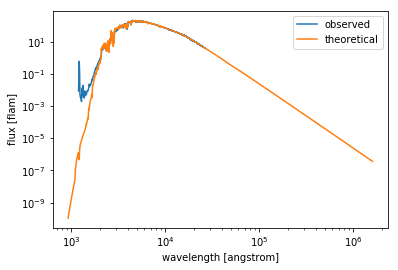

In [6]:
plt.loglog(sun_obs.wavelength.magnitude, sun_obs.flux.magnitude, label='observed')
plt.loglog(sun_th.wavelength.magnitude, sun_th.flux.magnitude, label='theoretical')
plt.legend();
plt.xlabel('wavelength [{0:s}]'.format(str(sun_obs.wavelength.units)));
plt.ylabel('flux [{0:s}]'.format(str(sun_obs.flux.units)));

One can see the differences between the two flavors.
The theoretical spectrum is scaled to match the observed spectrum from 1.5 - 2.5 microns, and then it is used where the observed spectrum ends. The theoretical model of the Sun from Kurucz‘93 atlas using the following parameters when the Sun is at 1 au.

|log_Z | T_eff | log_g | V$_{Johnson}$ |
|------|-------|-------|---------------|
|+0.0  | 5777  |+4.44  | -26.76        |

The Sun is also know to have a Johnson V (vega-)magnitude of -26.76 mag.

Let's verify this.

In [7]:
f = lib['GROUND_JOHNSON_V']
for name, sun in zip(('observed', 'theoretical', 'th. 10pc'), (sun_obs,sun_th, sun_th_10pc)):
    flux = f.get_flux(sun.wavelength, sun.flux)
    vegamag = f.Vega_zero_mag
    print('{0:12s} {1:0.5e} {2:+3.4f}'.format(name, flux.magnitude, -2.5 * np.log10(flux.magnitude) - vegamag))

observed     1.84614e+02 -26.7648
theoretical  1.84436e+02 -26.7637
th. 10pc     4.33506e-11 +4.8084


In [8]:
filter_names = ['GROUND_JOHNSON_B', 'GROUND_JOHNSON_V', 'GROUND_BESSELL_J', 'GROUND_BESSELL_K']
filter_names +=  lib.find('GaiaDR2')

filters = lib.load_filters(filter_names, lamb=sun_th.wavelength)

In [9]:
mags = {}
for name, fn in zip(filter_names, filters):
    flux = fn.get_flux(sun_th.wavelength, sun_th.flux)
    vegamag = fn.Vega_zero_mag
    mag = -2.5 * np.log10(flux.magnitude) - vegamag
    mags[name] = mag
    print('{0:>25s} {1:+3.4f} mag'.format(name, mag))

         GROUND_JOHNSON_B -26.0709 mag
         GROUND_JOHNSON_V -26.7637 mag
         GROUND_BESSELL_J -27.8970 mag
         GROUND_BESSELL_K -28.2706 mag
               GaiaDR2_BP -26.5833 mag
                GaiaDR2_G -26.9171 mag
               GaiaDR2_RP -27.4022 mag
  GaiaDR2_weiler_BPbright -26.5835 mag
   GaiaDR2_weiler_BPfaint -26.5560 mag
         GaiaDR2_weiler_G -26.9115 mag
        GaiaDR2_weiler_RP -27.4055 mag
             GaiaDR2v2_BP -26.5868 mag
              GaiaDR2v2_G -26.9101 mag
             GaiaDR2v2_RP -27.3971 mag


In [10]:
colors = (('GROUND_JOHNSON_B', 'GROUND_JOHNSON_V'),
          ('GROUND_JOHNSON_V', 'GROUND_BESSELL_K'),
          ('GROUND_BESSELL_J', 'GROUND_BESSELL_K'),
          ('GaiaDR2_BP', 'GaiaDR2_RP'),
          ('GaiaDR2_BP', 'GaiaDR2_G'),
          ('GaiaDR2_G', 'GaiaDR2_RP'),
          ('GaiaDR2v2_BP', 'GaiaDR2v2_RP'),
          ('GaiaDR2v2_BP', 'GaiaDR2v2_G'),
          ('GaiaDR2v2_G', 'GaiaDR2v2_RP'),
          ('GaiaDR2_weiler_BPbright', 'GaiaDR2_weiler_RP'),
          ('GaiaDR2_weiler_BPfaint', 'GaiaDR2_weiler_RP'),
          ('GaiaDR2_weiler_BPbright', 'GaiaDR2_weiler_G'),
          ('GaiaDR2_weiler_BPfaint', 'GaiaDR2_weiler_G'),
          ('GaiaDR2_weiler_G', 'GaiaDR2_weiler_RP'))

color_values = {}

for color in colors:
    color_values[color] = mags[color[0]] - mags[color[1]]
    print('{0:>25s} - {1:<25s} = {2:3.4f} mag'.format(color[0], color[1], mags[color[0]] - mags[color[1]]))
          

         GROUND_JOHNSON_B - GROUND_JOHNSON_V          = 0.6928 mag
         GROUND_JOHNSON_V - GROUND_BESSELL_K          = 1.5069 mag
         GROUND_BESSELL_J - GROUND_BESSELL_K          = 0.3735 mag
               GaiaDR2_BP - GaiaDR2_RP                = 0.8188 mag
               GaiaDR2_BP - GaiaDR2_G                 = 0.3337 mag
                GaiaDR2_G - GaiaDR2_RP                = 0.4851 mag
             GaiaDR2v2_BP - GaiaDR2v2_RP              = 0.8103 mag
             GaiaDR2v2_BP - GaiaDR2v2_G               = 0.3233 mag
              GaiaDR2v2_G - GaiaDR2v2_RP              = 0.4870 mag
  GaiaDR2_weiler_BPbright - GaiaDR2_weiler_RP         = 0.8220 mag
   GaiaDR2_weiler_BPfaint - GaiaDR2_weiler_RP         = 0.8495 mag
  GaiaDR2_weiler_BPbright - GaiaDR2_weiler_G          = 0.3280 mag
   GaiaDR2_weiler_BPfaint - GaiaDR2_weiler_G          = 0.3555 mag
         GaiaDR2_weiler_G - GaiaDR2_weiler_RP         = 0.4940 mag
